# **1. 데이터 차원**
- 불균형 데이터에 대한 처리 부분 추가  
  -> **가중 무작위 샘플링(Weighted Random Sampling)** 활용
- Albumentation 적용

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss --- 가중치 적용
- 배치/ Epoch
    - batch size: 128
    - Epoch: 100
    - EarlyStopping 적용

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **Random Sampling**

In [3]:
### 가중치 함수

def make_weights(df,classes):
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        weight = 1 / count    
        weights = [weight] * count    # 라벨이 뽑힐 가중치를 count의 역수로 동일하게 전체 라벨에 할당 
        weight_list += weights
 
    return weight_list

In [4]:
### 데이터 가져오기
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

In [5]:
### 가중치 생성

feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
weights = make_weights(train_data_df,feelings_list)
# print(weights)

### **DataLoader**

In [6]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [8]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [9]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [10]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    
    weights = make_weights(train_data_df,feelings_list)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,sampler = sampler, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [11]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [12]:
from torchsummary import summary

In [13]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [14]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [15]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target).to(device) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [16]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [17]:
### 가중 손실 함수

def get_class_weights(df,classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnt_lists = [] # 각 클래스의 데이터 수 저장
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        cnt_lists.append(count)
    
    weights = [1-(x / sum(cnt_lists)) for x in cnt_lists]
    class_weights = torch.cuda.FloatTensor(weights).to(device) # 가중치 설정
    
    return class_weights


### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weights = get_class_weights(train_data_df,feelings_list)
# print(class_weights)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean') # 가중 손실 함수
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10, verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/227 - Running loss: 1.9522291421890259
30/227 - Running loss: 1.889363169670105
60/227 - Running loss: 1.8155786991119385
90/227 - Running loss: 1.8115631341934204
120/227 - Running loss: 1.8047856092453003
150/227 - Running loss: 1.7439402341842651
180/227 - Running loss: 1.7041797637939453
210/227 - Running loss: 1.656516194343567
1/100-Train Loss:1.7867030992381898, Val Loss:1.7104767108785695
1/100-Train Acc:0.3740363436123348, Val Acc:0.44323038427819983
0/227 - Running loss: 1.686926007270813
30/227 - Running loss: 1.6830666065216064
60/227 - Running loss: 1.7445145845413208
90/227 - Running loss: 1.7744994163513184
120/227 - Running loss: 1.6328043937683105
150/227 - Running loss: 1.6622275114059448
180/227 - Running loss: 1.60248863697052
210/227 - Running loss: 1.6256637573242188
2/100-Train Loss:1.689056045158319, Val Loss:1.6734578609466553
2/100-Train Acc:0.4842373348017621, Val Acc:0.48063997662185853
0/227 - Running loss: 1.6461870670318604
30/227 - Running loss: 1.7134

0/227 - Running loss: 1.5224825143814087
30/227 - Running loss: 1.5545635223388672
60/227 - Running loss: 1.5531256198883057
90/227 - Running loss: 1.4690473079681396
120/227 - Running loss: 1.4919170141220093
150/227 - Running loss: 1.5095958709716797
180/227 - Running loss: 1.539150595664978
210/227 - Running loss: 1.5481573343276978
18/100-Train Loss:1.5195120410246996, Val Loss:1.5653401078849003
18/100-Train Acc:0.6661618942731278, Val Acc:0.5962521917007598
0/227 - Running loss: 1.468879222869873
30/227 - Running loss: 1.5150598287582397
60/227 - Running loss: 1.5561230182647705
90/227 - Running loss: 1.4888964891433716
120/227 - Running loss: 1.4797567129135132
150/227 - Running loss: 1.5680160522460938
180/227 - Running loss: 1.5419245958328247
210/227 - Running loss: 1.4561200141906738
EarlyStopping counter: 1 out of 10
19/100-Train Loss:1.5065040036970299, Val Loss:1.5686111080235448
19/100-Train Acc:0.6799972466960352, Val Acc:0.5918139976621859
0/227 - Running loss: 1.46758

EarlyStopping counter: 3 out of 10
34/100-Train Loss:1.466320655944589, Val Loss:1.5737740006940117
34/100-Train Acc:0.7186467511013216, Val Acc:0.5872753506721216
0/227 - Running loss: 1.5207290649414062
30/227 - Running loss: 1.4319987297058105
60/227 - Running loss: 1.4941960573196411
90/227 - Running loss: 1.4263602495193481
120/227 - Running loss: 1.4533209800720215
150/227 - Running loss: 1.4962571859359741
180/227 - Running loss: 1.4475187063217163
210/227 - Running loss: 1.396876573562622
35/100-Train Loss:1.4538166213140613, Val Loss:1.524269885030286
35/100-Train Acc:0.7302106277533039, Val Acc:0.6380132232612507
0/227 - Running loss: 1.4210795164108276
30/227 - Running loss: 1.4616034030914307
60/227 - Running loss: 1.48079252243042
90/227 - Running loss: 1.4388474225997925
120/227 - Running loss: 1.40950608253479
150/227 - Running loss: 1.4181371927261353
180/227 - Running loss: 1.4897880554199219
210/227 - Running loss: 1.4712542295455933
EarlyStopping counter: 1 out of 10

180/227 - Running loss: 1.3483996391296387
210/227 - Running loss: 1.3857080936431885
51/100-Train Loss:1.3798696243815485, Val Loss:1.5049685363111824
51/100-Train Acc:0.7862403634361234, Val Acc:0.6565559248977206
0/227 - Running loss: 1.3712236881256104
30/227 - Running loss: 1.3862745761871338
60/227 - Running loss: 1.4035035371780396
90/227 - Running loss: 1.3261957168579102
120/227 - Running loss: 1.3630520105361938
150/227 - Running loss: 1.4133225679397583
180/227 - Running loss: 1.374220848083496
210/227 - Running loss: 1.384937047958374
EarlyStopping counter: 1 out of 10
52/100-Train Loss:1.3734640471210564, Val Loss:1.505325148845541
52/100-Train Acc:0.7922632158590308, Val Acc:0.658396040327294
0/227 - Running loss: 1.4015318155288696
30/227 - Running loss: 1.4454498291015625
60/227 - Running loss: 1.4601268768310547
90/227 - Running loss: 1.386709213256836
120/227 - Running loss: 1.4007421731948853
150/227 - Running loss: 1.380242109298706
180/227 - Running loss: 1.3784832

0/227 - Running loss: 1.3953849077224731
30/227 - Running loss: 1.3248423337936401
60/227 - Running loss: 1.355788230895996
90/227 - Running loss: 1.3567174673080444
120/227 - Running loss: 1.3293308019638062
150/227 - Running loss: 1.3742895126342773
180/227 - Running loss: 1.3757413625717163
210/227 - Running loss: 1.3440736532211304
EarlyStopping counter: 7 out of 10
68/100-Train Loss:1.3547009975374533, Val Loss:1.5026696591541684
68/100-Train Acc:0.8086453744493393, Val Acc:0.6592498904149621
0/227 - Running loss: 1.3799294233322144
30/227 - Running loss: 1.310074806213379
60/227 - Running loss: 1.399662971496582
90/227 - Running loss: 1.297659993171692
120/227 - Running loss: 1.3860868215560913
150/227 - Running loss: 1.325913906097412
180/227 - Running loss: 1.3037083148956299
210/227 - Running loss: 1.4020073413848877
EarlyStopping counter: 8 out of 10
69/100-Train Loss:1.3511479410305947, Val Loss:1.502417724708031
69/100-Train Acc:0.8123279185022027, Val Acc:0.660058080070134

180/227 - Running loss: 1.3305221796035767
210/227 - Running loss: 1.3277103900909424
Epoch 00084: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 6 out of 10
84/100-Train Loss:1.350698822920543, Val Loss:1.5018225373892948
84/100-Train Acc:0.8124655837004405, Val Acc:0.6592498904149621
0/227 - Running loss: 1.3820536136627197
30/227 - Running loss: 1.3595303297042847
60/227 - Running loss: 1.3726563453674316
90/227 - Running loss: 1.3747501373291016
120/227 - Running loss: 1.3666622638702393
150/227 - Running loss: 1.3537206649780273
180/227 - Running loss: 1.344947338104248
210/227 - Running loss: 1.3814419507980347
EarlyStopping counter: 7 out of 10
85/100-Train Loss:1.3529714540237898, Val Loss:1.5018278483686776
85/100-Train Acc:0.8099531938325991, Val Acc:0.6592498904149621
0/227 - Running loss: 1.3383289575576782
30/227 - Running loss: 1.3646219968795776
60/227 - Running loss: 1.343900442123413
90/227 - Running loss: 1.3308333158493042
120/227 - Running l

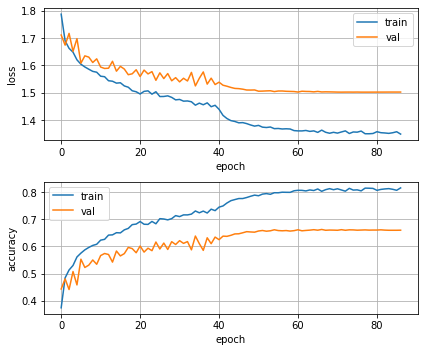

In [20]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()

- batch size 64에 비해 성능이 향상되었음(0.6133 -> 0.6622)